# **Walmart**

In [48]:
#https://www.kaggle.com/code/aslanahmedov/walmart-sales-forecasting/notebook#Findings-and-Explorations
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_classif, f_regression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error,mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

In [2]:
feature='features.csv'
store='stores.csv'
train='train.csv'
test='test.csv'

df_train=pd.read_csv(train,sep=',')
df_test=pd.read_csv(test,sep=',')
df_store=pd.read_csv(store,sep=',')
df_feature=pd.read_csv(feature,sep=',')

In [3]:
print(df_train.shape)
print(df_test.shape)
print(df_store.shape)
print(df_feature.shape)

(421570, 5)
(115064, 4)
(45, 3)
(8190, 12)


In [4]:
# analizar el train
print(df_train.isnull().sum())
print('----------------------------')
print(df_test.isnull().sum())
print('----------------------------')
print(df_store.isnull().sum())
print('----------------------------')
print(df_feature.isnull().sum())

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
dtype: int64
----------------------------
Store        0
Dept         0
Date         0
IsHoliday    0
dtype: int64
----------------------------
Store    0
Type     0
Size     0
dtype: int64
----------------------------
Store              0
Date               0
Temperature        0
Fuel_Price         0
MarkDown1       4158
MarkDown2       5269
MarkDown3       4577
MarkDown4       4726
MarkDown5       4140
CPI              585
Unemployment     585
IsHoliday          0
dtype: int64


## **First Look to Data Merge**

In [5]:
df_train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [6]:
df_feature.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [7]:
df_store.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [8]:
# todas las tablas se relacionan por el store
df=df_train.merge(df_feature,on=['Store','Date'],how='inner').merge(df_store,on=['Store'],how='inner')
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
3,1,4,2010-02-05,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
4,1,5,2010-02-05,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315


In [9]:
print(df.shape)
df.drop(['IsHoliday_y'], axis=1,inplace=True) 
df.rename(columns={'IsHoliday_x':'IsHoliday'},inplace=True)
df.head()

(421570, 17)


,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
3,1,4,2010-02-05,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
4,1,5,2010-02-05,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315


## **Store & Department**

In [10]:
print(f'Store = {df['Store'].nunique()}')
print(f'Dept = {df['Dept'].nunique()}')

Store = 45
Dept = 81


In [11]:
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
3,1,4,2010-02-05,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
4,1,5,2010-02-05,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315


In [12]:
store_dept=pd.pivot_table(df,index='Store',columns='Dept',values='Weekly_Sales',
                          aggfunc=np.mean)
store_dept.head()

Dept,1,2,3,4,5,6,7,8,9,10,...,90,91,92,93,94,95,96,97,98,99
Store,,,,,,,,,,,,,,,,,,,,,
1,22513.322937,46102.090420,13150.478042,36964.154476,24257.941119,4801.780140,24566.487413,35718.257622,28062.052238,31033.386364,...,82427.547832,64238.943427,135458.969510,71699.182378,63180.568182,120772.062168,33251.831639,35207.348811,11827.770769,306.091081
2,30777.980769,65912.922517,17476.563357,45607.666573,30555.315315,6808.382517,40477.837063,58707.369441,34375.864476,38845.854476,...,97611.537133,80610.380350,164840.230979,70581.977063,70018.672517,143588.751888,34319.063846,40697.204056,14035.400839,475.896905
3,7328.621049,16841.775664,5509.300769,8434.186503,11695.366573,2012.411818,10044.341608,8310.254196,9062.007692,10871.944126,...,1540.049161,318.685594,7568.280210,NaN,656.294444,15745.528252,3934.540000,343.437357,30.570833,NaN
4,36979.940070,93639.315385,19012.491678,56603.400140,45668.406783,8241.777692,50728.151399,62949.723776,34437.170979,37269.667413,...,89248.965524,66535.407203,159365.107902,67815.163007,68159.106573,147236.473706,38346.573077,39339.238951,15009.249371,623.182381
5,9774.553077,12317.953287,4101.085175,9860.806783,6699.202238,1191.057622,6124.484336,13735.709441,7919.805944,9783.395385,...,3059.520000,1457.221678,7759.205594,NaN,411.431486,19340.693986,5985.671119,667.070315,29.976087,NaN


In [13]:
df.loc[df['Weekly_Sales']<=0]

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
188,1,47,2010-02-19,-863.00,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
406,1,47,2010-03-12,-698.00,False,57.79,2.667,NaN,NaN,NaN,NaN,NaN,211.380643,8.106,A,151315
2549,1,47,2010-10-08,-58.00,False,63.93,2.633,NaN,NaN,NaN,NaN,NaN,211.746754,7.838,A,151315
3632,1,54,2011-01-21,-50.00,False,44.04,3.016,NaN,NaN,NaN,NaN,NaN,211.827234,7.742,A,151315
4132,1,47,2011-03-11,0.00,False,53.56,3.459,NaN,NaN,NaN,NaN,NaN,214.111056,7.742,A,151315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420066,45,49,2012-05-25,-4.97,False,67.21,3.798,5370.39,NaN,361.22,1287.62,2461.81,191.002810,8.567,B,118221
420403,45,49,2012-06-29,-34.00,False,75.22,3.506,3291.36,425.60,NaN,314.88,2255.34,191.099246,8.567,B,118221
420736,45,49,2012-08-03,-1.91,False,76.58,3.654,24853.05,39.56,17.96,11142.69,2768.32,191.164090,8.684,B,118221
421007,45,54,2012-08-31,0.00,False,75.09,3.867,23641.30,6.00,92.93,6988.31,3992.13,191.461281,8.684,B,118221


## **Dates**

In [14]:
df_holiday = df.loc[df['IsHoliday']==True]
print(df_holiday['Date'].unique())
df_not_holiday = df.loc[df['IsHoliday']==False]
print(df_not_holiday['Date'].nunique()) 

['2010-02-12' '2010-09-10' '2010-11-26' '2010-12-31' '2011-02-11'
 '2011-09-09' '2011-11-25' '2011-12-30' '2012-02-10' '2012-09-07']
133


In [15]:
# Super bowl dates in train set
df.loc[(df['Date'] == '2010-02-12')|(df['Date'] == '2011-02-11')|(df['Date'] == '2012-02-10'),'Super_Bowl'] = True
df.loc[(df['Date'] != '2010-02-12')&(df['Date'] != '2011-02-11')&(df['Date'] != '2012-02-10'),'Super_Bowl'] = False
# Labor day dates in train set
df.loc[(df['Date'] == '2010-09-10')|(df['Date'] == '2011-09-09')|(df['Date'] == '2012-09-07'),'Labor_Day'] = True
df.loc[(df['Date'] != '2010-09-10')&(df['Date'] != '2011-09-09')&(df['Date'] != '2012-09-07'),'Labor_Day'] = False

# Thanksgiving dates in train set
df.loc[(df['Date'] == '2010-11-26')|(df['Date'] == '2011-11-25'),'Thanksgiving'] = True
df.loc[(df['Date'] != '2010-11-26')&(df['Date'] != '2011-11-25'),'Thanksgiving'] = False

#Christmas dates in train set
df.loc[(df['Date'] == '2010-12-31')|(df['Date'] == '2011-12-30'),'Christmas'] = True
df.loc[(df['Date'] != '2010-12-31')&(df['Date'] != '2011-12-30'),'Christmas'] = False

In [16]:
free_days=['Super_Bowl','Labor_Day', 'Thanksgiving', 'Christmas']

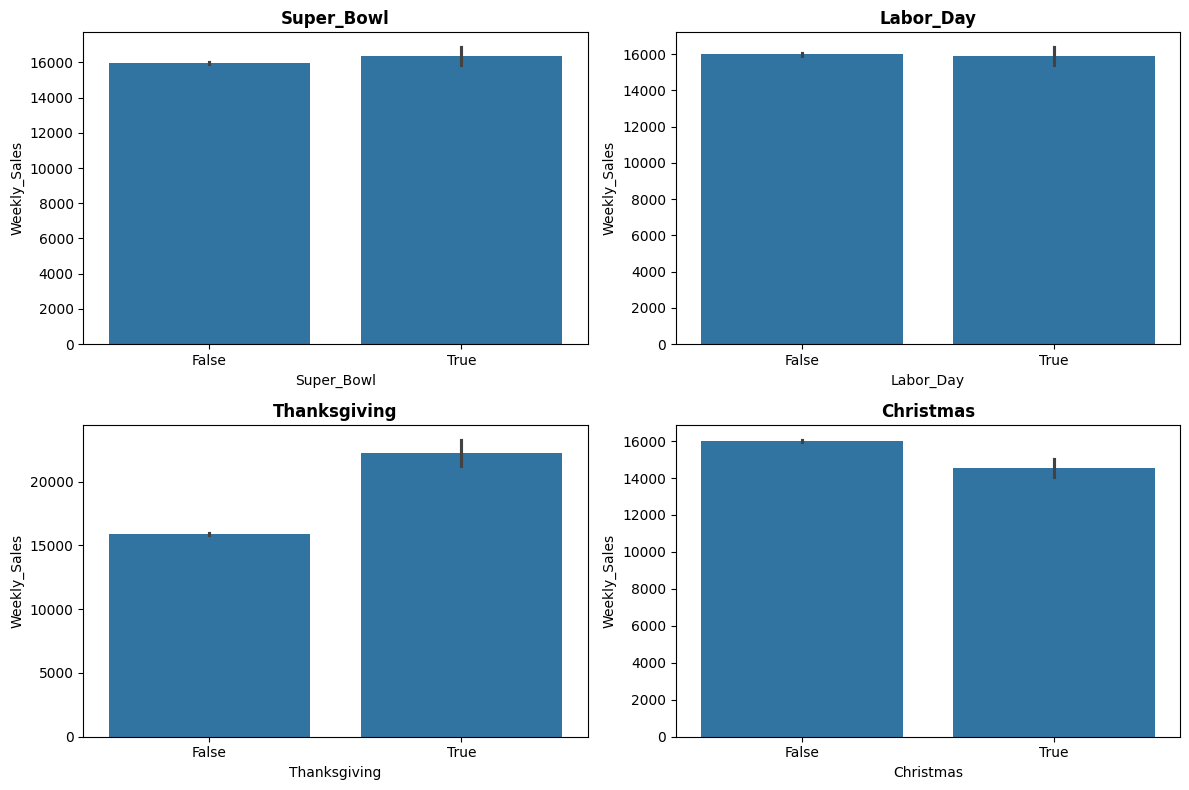

In [17]:
# Crear una figura y una cuadrícula de 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # 2 filas, 2 columnas
# Desenrollar los ejes en una lista para iterar más fácilmente
axes = axes.flatten()
# Generar gráficos
for i, ax in enumerate(free_days):
    sns.barplot(data=df, x=ax, y='Weekly_Sales', ax=axes[i])
    axes[i].set_title(ax, fontsize=12, weight='bold')
# Ajustar la distribución de los subplots
plt.tight_layout()
plt.show()

## **Markdown Columns**

In [18]:
df.isnull().sum()

Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
Type                 0
Size                 0
Super_Bowl           0
Labor_Day            0
Thanksgiving         0
Christmas            0
dtype: int64

In [19]:
# replace the null with 0
df=df.fillna(0)
print(df.isnull().sum())

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
Type            0
Size            0
Super_Bowl      0
Labor_Day       0
Thanksgiving    0
Christmas       0
dtype: int64


In [20]:
df.describe()

,Store,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size
count,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123,60.090059,3.361027,2590.074819,879.974298,468.087665,1083.132268,1662.772385,171.201947,7.960289,136727.915739
std,12.785297,30.492054,22711.183519,18.447931,0.458515,6052.385934,5084.538801,5528.873453,3894.529945,4207.629321,39.159276,1.863296,60980.583328
min,1.000000,1.000000,-4988.940000,-2.060000,2.472000,0.000000,-265.760000,-29.100000,0.000000,0.000000,126.064000,3.879000,34875.000000
25%,11.000000,18.000000,2079.650000,46.680000,2.933000,0.000000,0.000000,0.000000,0.000000,0.000000,132.022667,6.891000,93638.000000
50%,22.000000,37.000000,7612.030000,62.090000,3.452000,0.000000,0.000000,0.000000,0.000000,0.000000,182.318780,7.866000,140167.000000
75%,33.000000,74.000000,20205.852500,74.280000,3.738000,2809.050000,2.200000,4.540000,425.290000,2168.040000,212.416993,8.572000,202505.000000
max,45.000000,99.000000,693099.360000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000,219622.000000


## **Deeper Look in Sales**

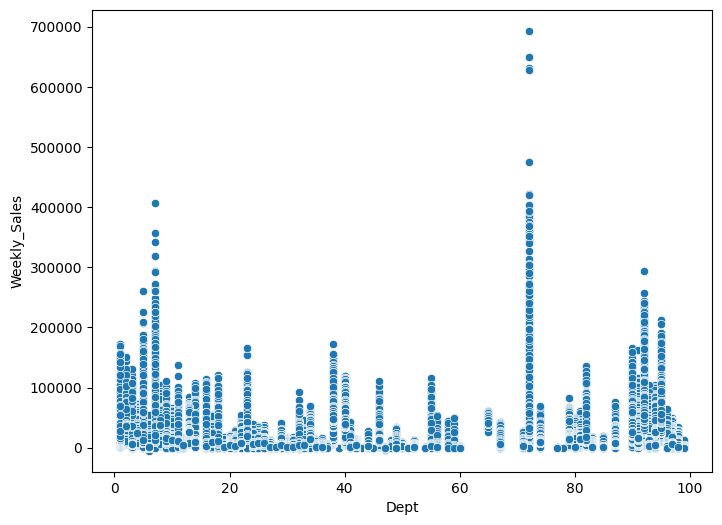

In [21]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=df,x='Dept',y='Weekly_Sales')
plt.show()

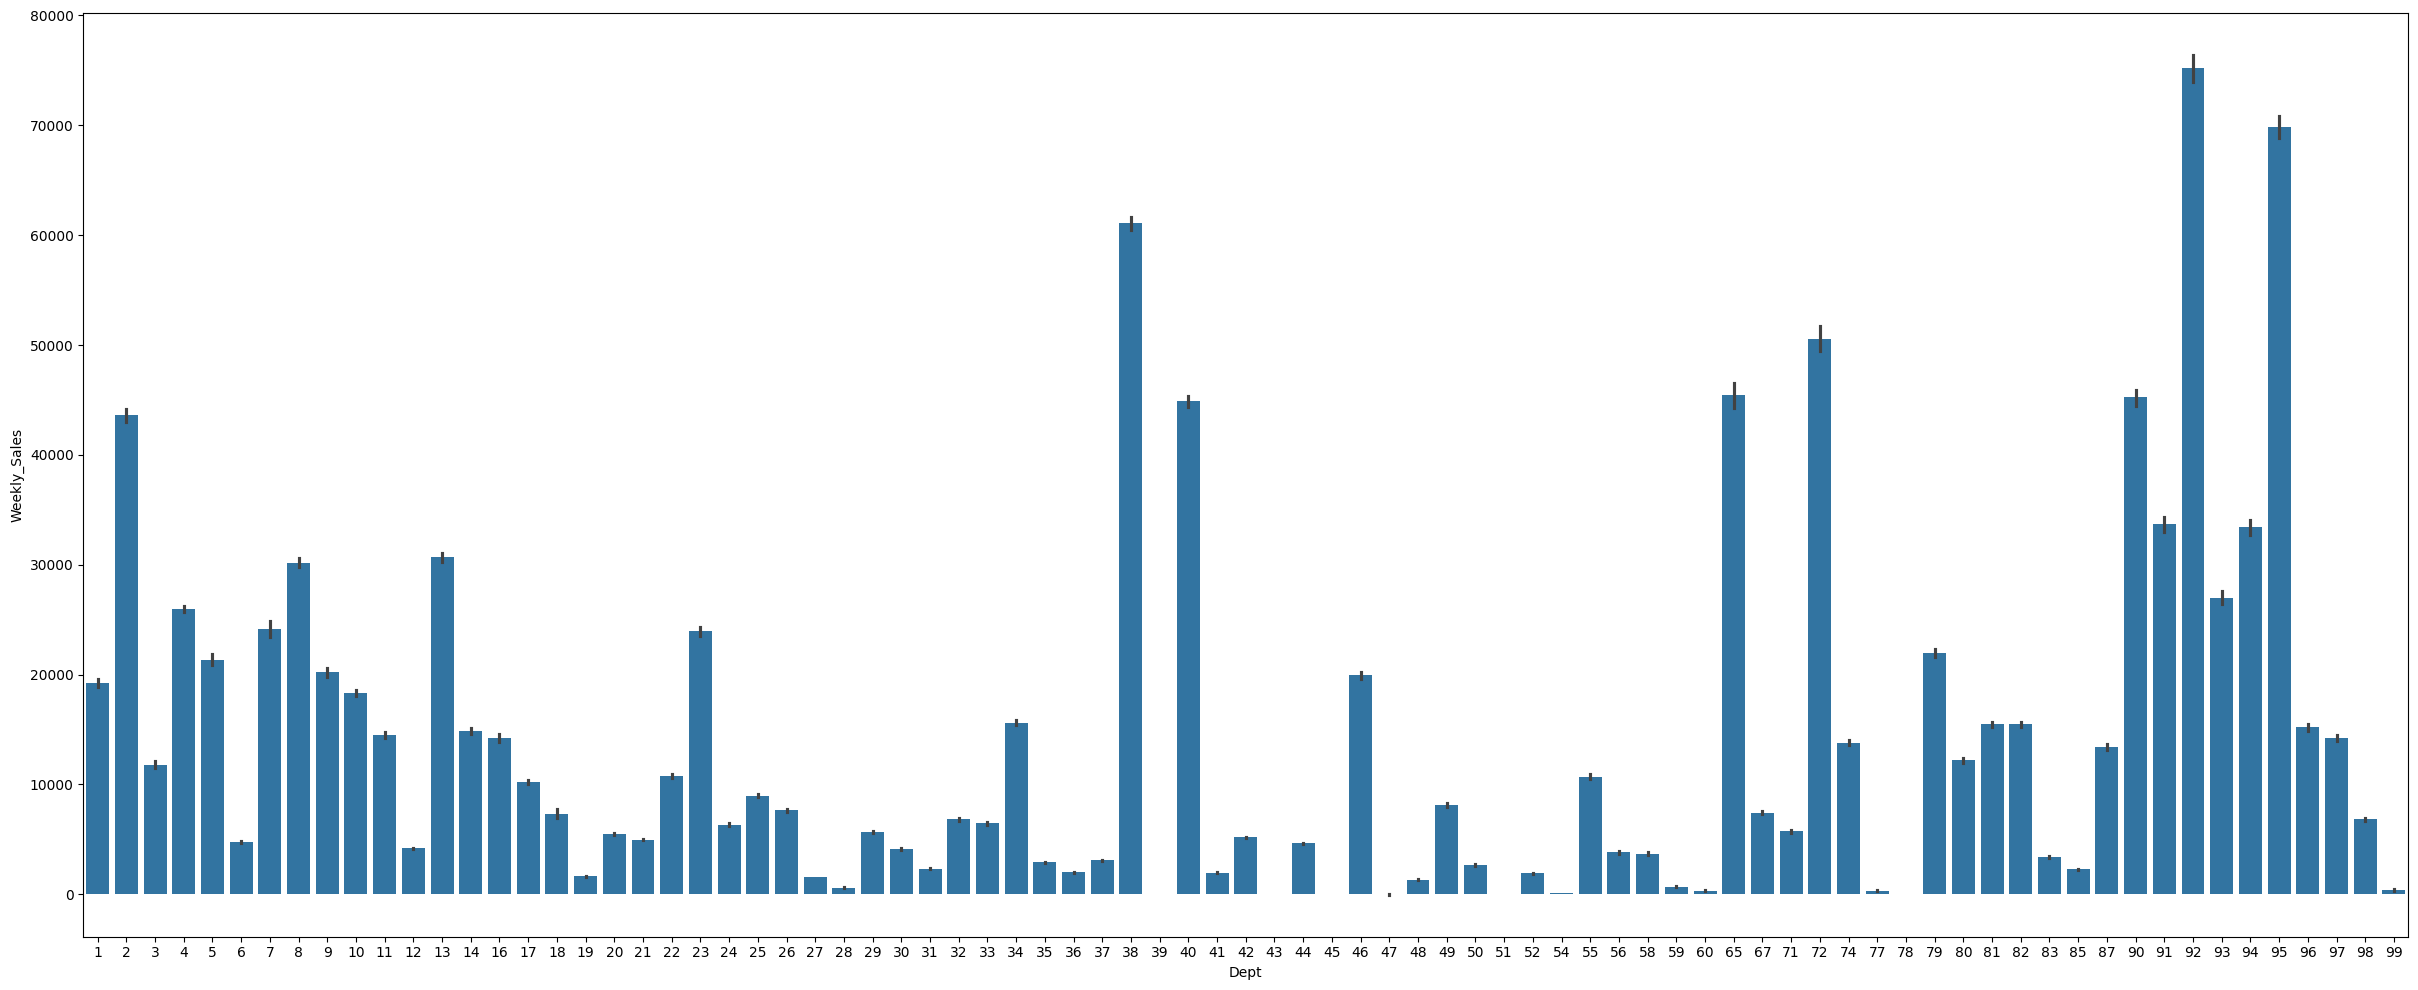

In [22]:
plt.figure(figsize=(30,12))
sns.barplot(data=df,x='Dept',y='Weekly_Sales')
plt.show()

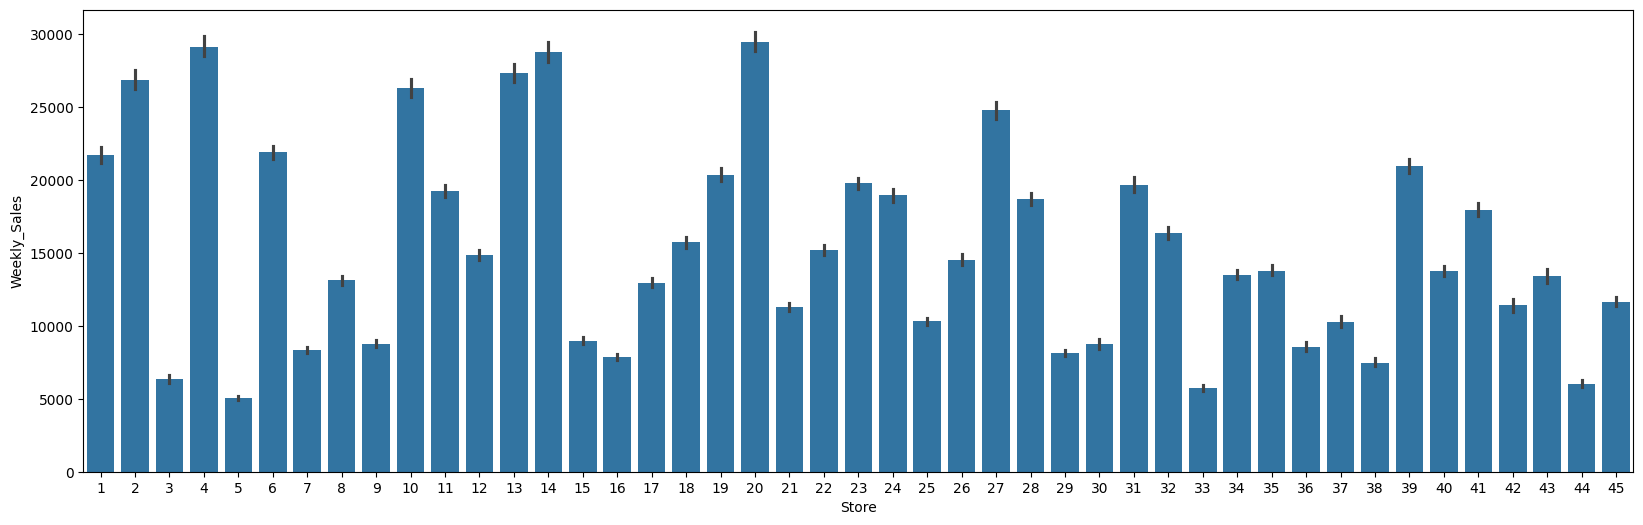

In [23]:
plt.figure(figsize=(20,6))
sns.barplot(data=df,x='Store', y='Weekly_Sales')
plt.show()

## **Changing Date to Datetime and Creating New Columns**

In [24]:
df['Date'] = pd.to_datetime(df['Date'])
df['week'] = df['Date'].dt.isocalendar().week
df['month'] = df['Date'].dt.month
df['year'] = df['Date'].dt.year

<Figure size 1000x800 with 0 Axes>

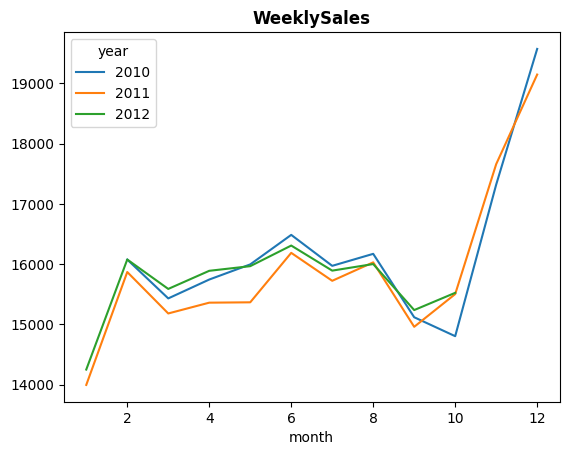

In [25]:
monthly_sales=pd.pivot_table(df,values='Weekly_Sales',columns='year',
                             index='month')
monthly_sales.head()

plt.figure(figsize=(10,8))
monthly_sales.plot()
plt.title('WeeklySales',fontsize=12,weight='bold')
plt.show()

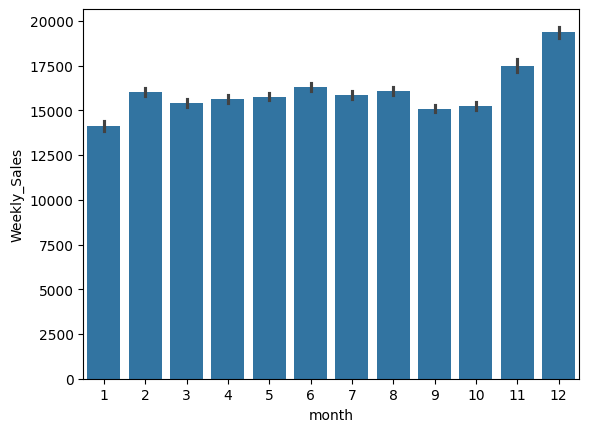

In [26]:
sns.barplot(data=df,x='month',y='Weekly_Sales')
plt.show()

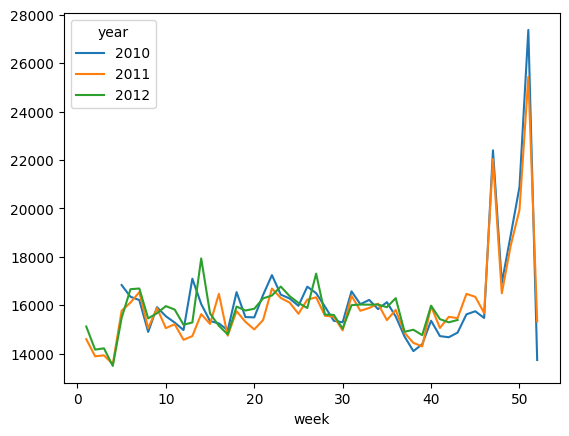

In [27]:
weekly_sales = pd.pivot_table(df, values = "Weekly_Sales", columns = "year", index = "week")
weekly_sales.plot()
plt.show()

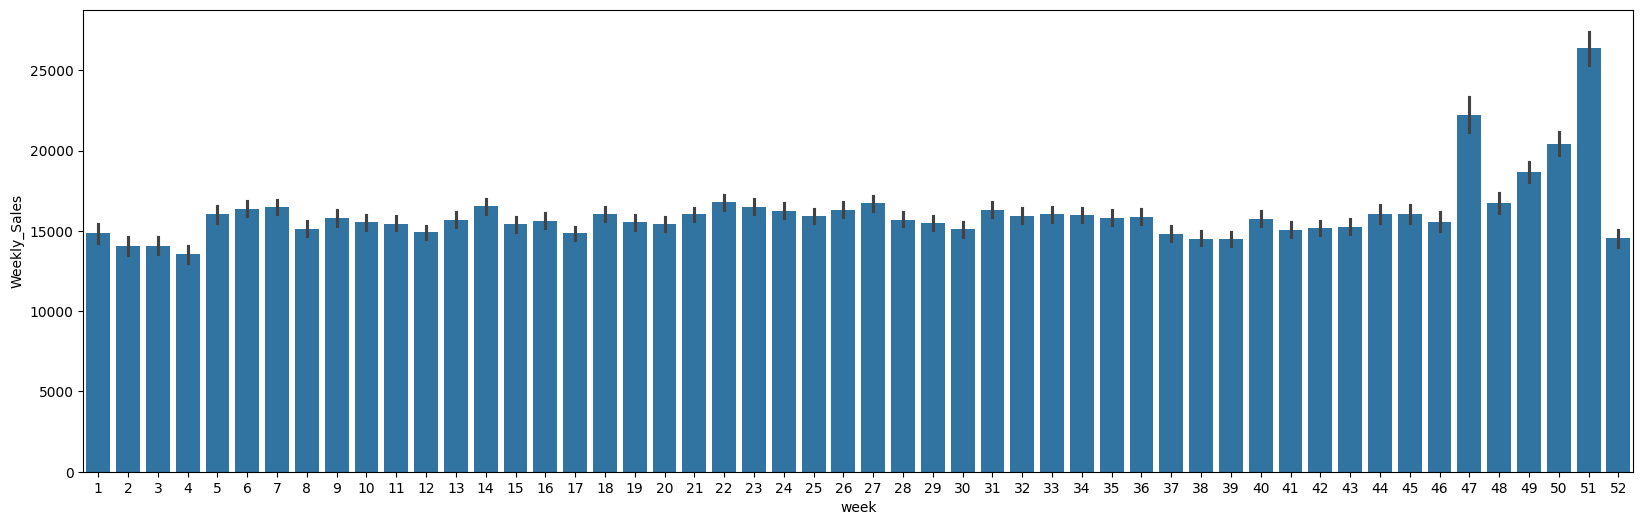

In [28]:
plt.figure(figsize=(20,6))
sns.barplot(data=df,x='week', y='Weekly_Sales')
plt.show()

## **Fuel Price, CPI, Unemployment, Temperature Effects**

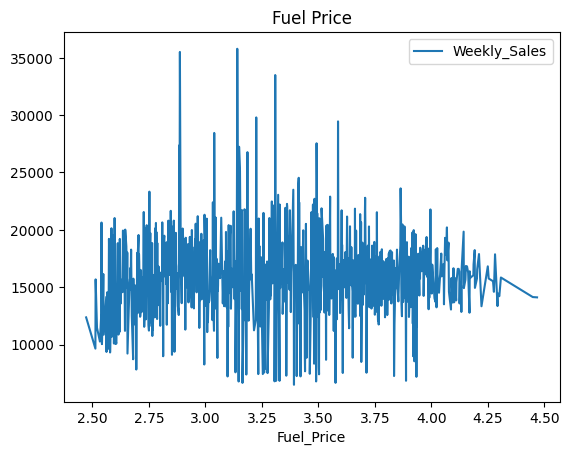

In [29]:
fuel_price = pd.pivot_table(df, values = "Weekly_Sales", index= "Fuel_Price")
fuel_price.plot()
plt.title('Fuel Price')
plt.show()

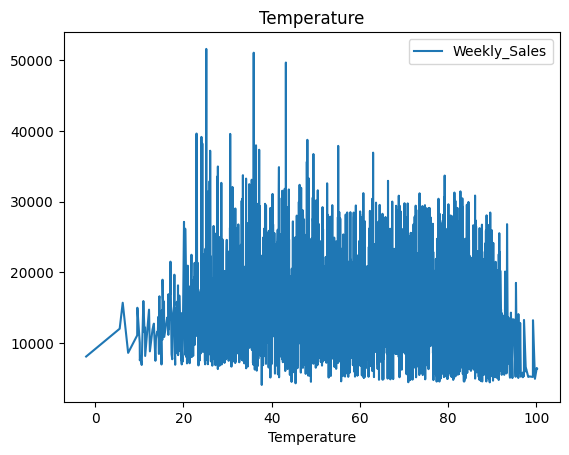

In [30]:
temp = pd.pivot_table(df, values = "Weekly_Sales", index= "Temperature")
temp.plot()
plt.title('Temperature')
plt.show()

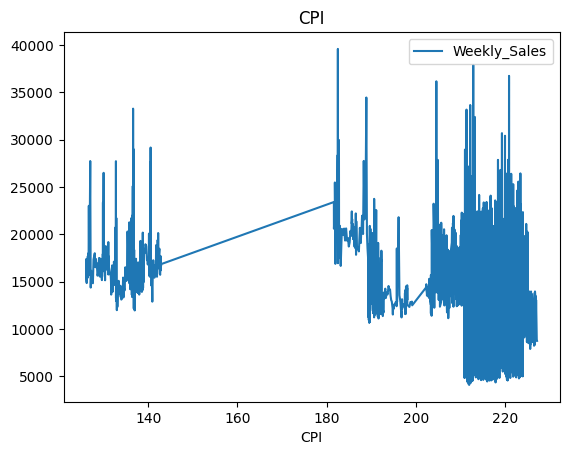

In [31]:
CPI = pd.pivot_table(df, values = "Weekly_Sales", index= "CPI")
CPI.plot()
plt.title('CPI')
plt.show()

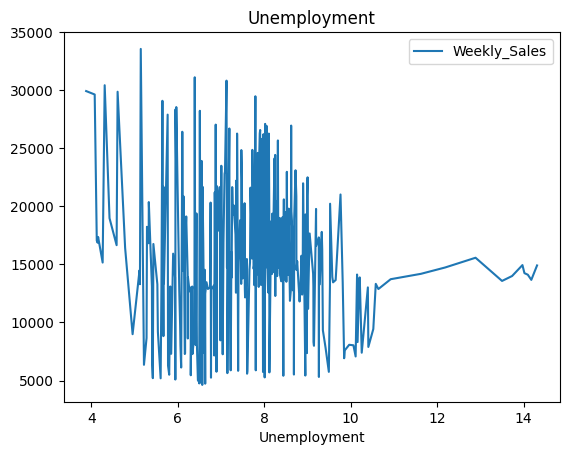

In [32]:
unemployment = pd.pivot_table(df, values = "Weekly_Sales", index= "Unemployment")
unemployment.plot()
plt.title('Unemployment')
plt.show()

## **Encoded Data**

In [33]:
df_encoded=df.copy()
df_encoded.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,...,Unemployment,Type,Size,Super_Bowl,Labor_Day,Thanksgiving,Christmas,week,month,year
0,1,1,2010-02-05,24924.50,False,42.31,2.572,0.0,0.0,0.0,...,8.106,A,151315,False,False,False,False,5,2,2010
1,1,2,2010-02-05,50605.27,False,42.31,2.572,0.0,0.0,0.0,...,8.106,A,151315,False,False,False,False,5,2,2010
2,1,3,2010-02-05,13740.12,False,42.31,2.572,0.0,0.0,0.0,...,8.106,A,151315,False,False,False,False,5,2,2010
3,1,4,2010-02-05,39954.04,False,42.31,2.572,0.0,0.0,0.0,...,8.106,A,151315,False,False,False,False,5,2,2010
4,1,5,2010-02-05,32229.38,False,42.31,2.572,0.0,0.0,0.0,...,8.106,A,151315,False,False,False,False,5,2,2010


In [34]:
free_days

['Super_Bowl', 'Labor_Day', 'Thanksgiving', 'Christmas']

In [35]:
for i in free_days:
    df_encoded[i]=df_encoded[i].astype(bool).astype(int)
type_group = {'A':1, 'B': 2, 'C': 3} 
df_encoded['Type']=df_encoded['Type'].replace(type_group)

In [36]:
for i in free_days:
    print(df_encoded[i].value_counts())

Super_Bowl
0    412675
1      8895
Name: count, dtype: int64
Labor_Day
0    412709
1      8861
Name: count, dtype: int64
Thanksgiving
0    415611
1      5959
Name: count, dtype: int64
Christmas
0    415624
1      5946
Name: count, dtype: int64


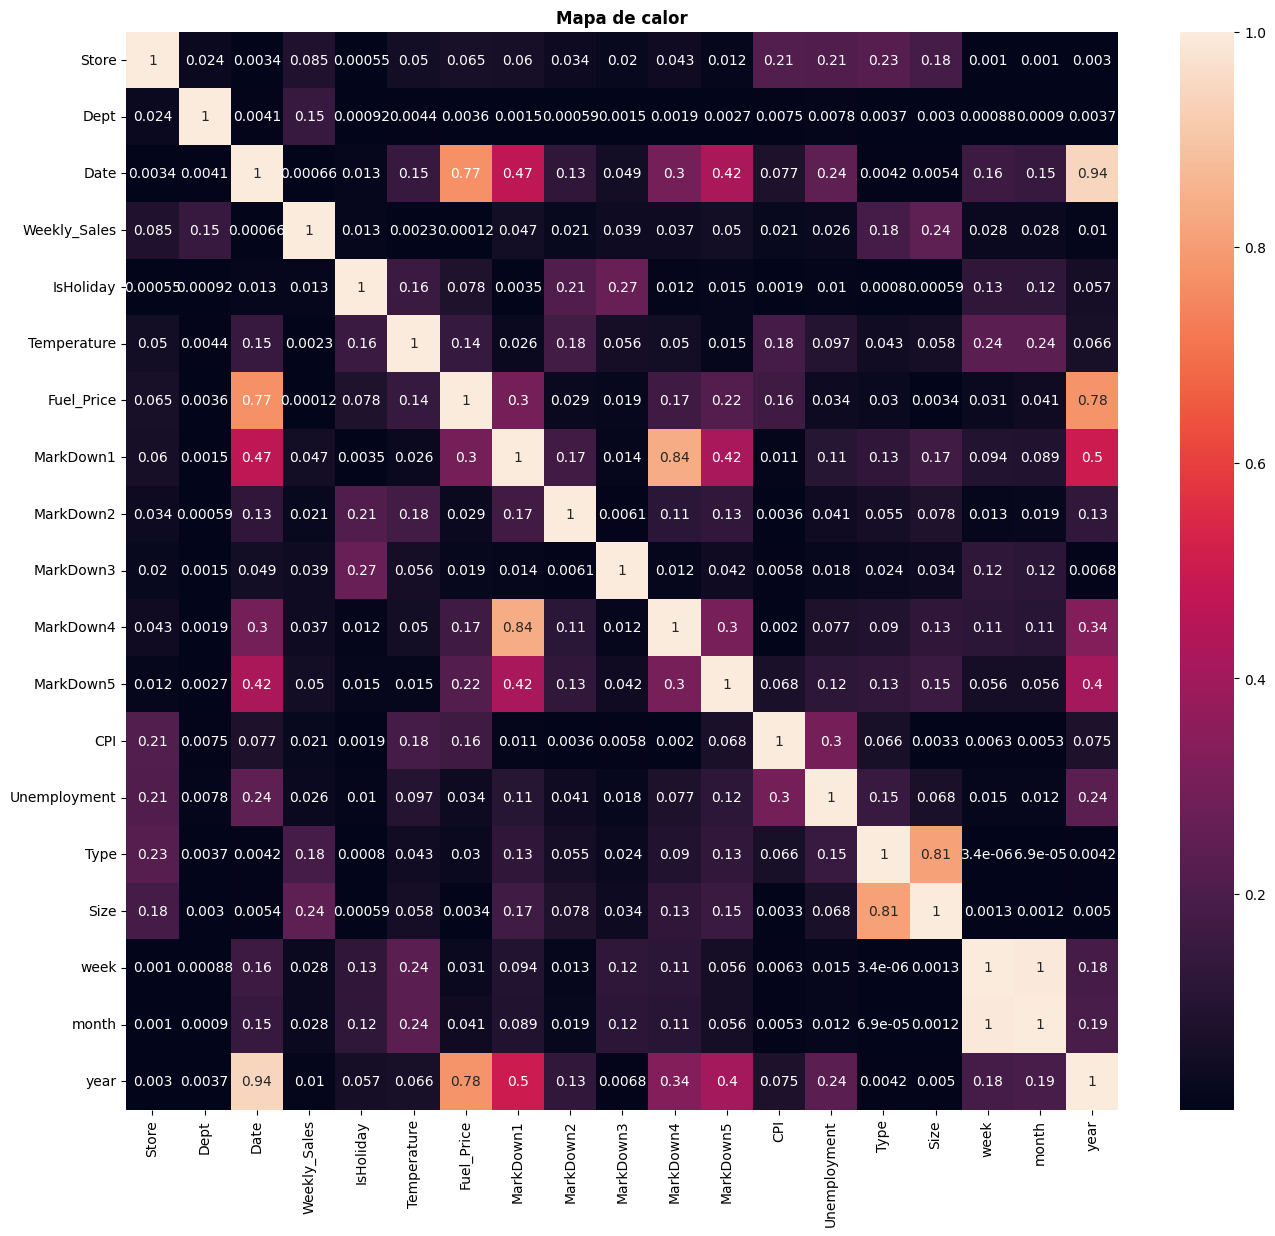

In [37]:
df_new=df_encoded.copy()
drop_col = ['Super_Bowl','Labor_Day','Thanksgiving','Christmas']
df_new.drop(drop_col, axis=1, inplace=True)
# Suponiendo que 'IsHoliday' tiene valores categóricos (0 y 1)
df_new['IsHoliday'] = df_new['IsHoliday'].astype(bool).astype(int)
plt.figure(figsize=(16,14))
sns.heatmap(df_new.corr().abs(),annot=True)
plt.title('Mapa de calor',fontsize=12,weight='bold')
plt.show()

In [38]:
# correlation
correlation_matrix = df_new.corr()
# correlacion con variable objetivo
correlation_with_target=correlation_matrix['Weekly_Sales'].sort_values()
# umbral de correlación significativo
threshold=0.010
low_correlation_features=correlation_with_target[abs(correlation_with_target)<threshold].index
print(f"Caracterisitica eliminadas por baja correlación",low_correlation_features)

Caracterisitica eliminadas por baja correlación Index(['Temperature', 'Date', 'Fuel_Price'], dtype='object')


In [39]:
# Supongamos que 'X' son las características y 'y' es la variable objetivo
X = df_new.drop(columns=['Weekly_Sales','Date'])
y = df_new['Weekly_Sales']

# Usar SelectKBest para seleccionar las mejores características basadas en correlación de Pearson
# Si es un problema de clasificación usa f_classif, para regresión usa f_regression
selector = SelectKBest(score_func=f_regression, k='all')  # k='all' para considerar todas las características
selector.fit(X, y)

# Obtener las puntuaciones de cada característica
scores = pd.Series(selector.scores_, index=X.columns)

# Definir un umbral para seleccionar las características relevantes
threshold = 0.010  # Puedes ajustar este valor según tus necesidades
selected_features = scores[scores > threshold].index

# Filtrar el DataFrame para mantener solo las características seleccionadas
X_selected = X[selected_features]

print("Características seleccionadas:")
print(selected_features)


Características seleccionadas:
Index(['Store', 'Dept', 'IsHoliday', 'Temperature', 'MarkDown1', 'MarkDown2',
       'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Type',
       'Size', 'week', 'month', 'year'],
      dtype='object')


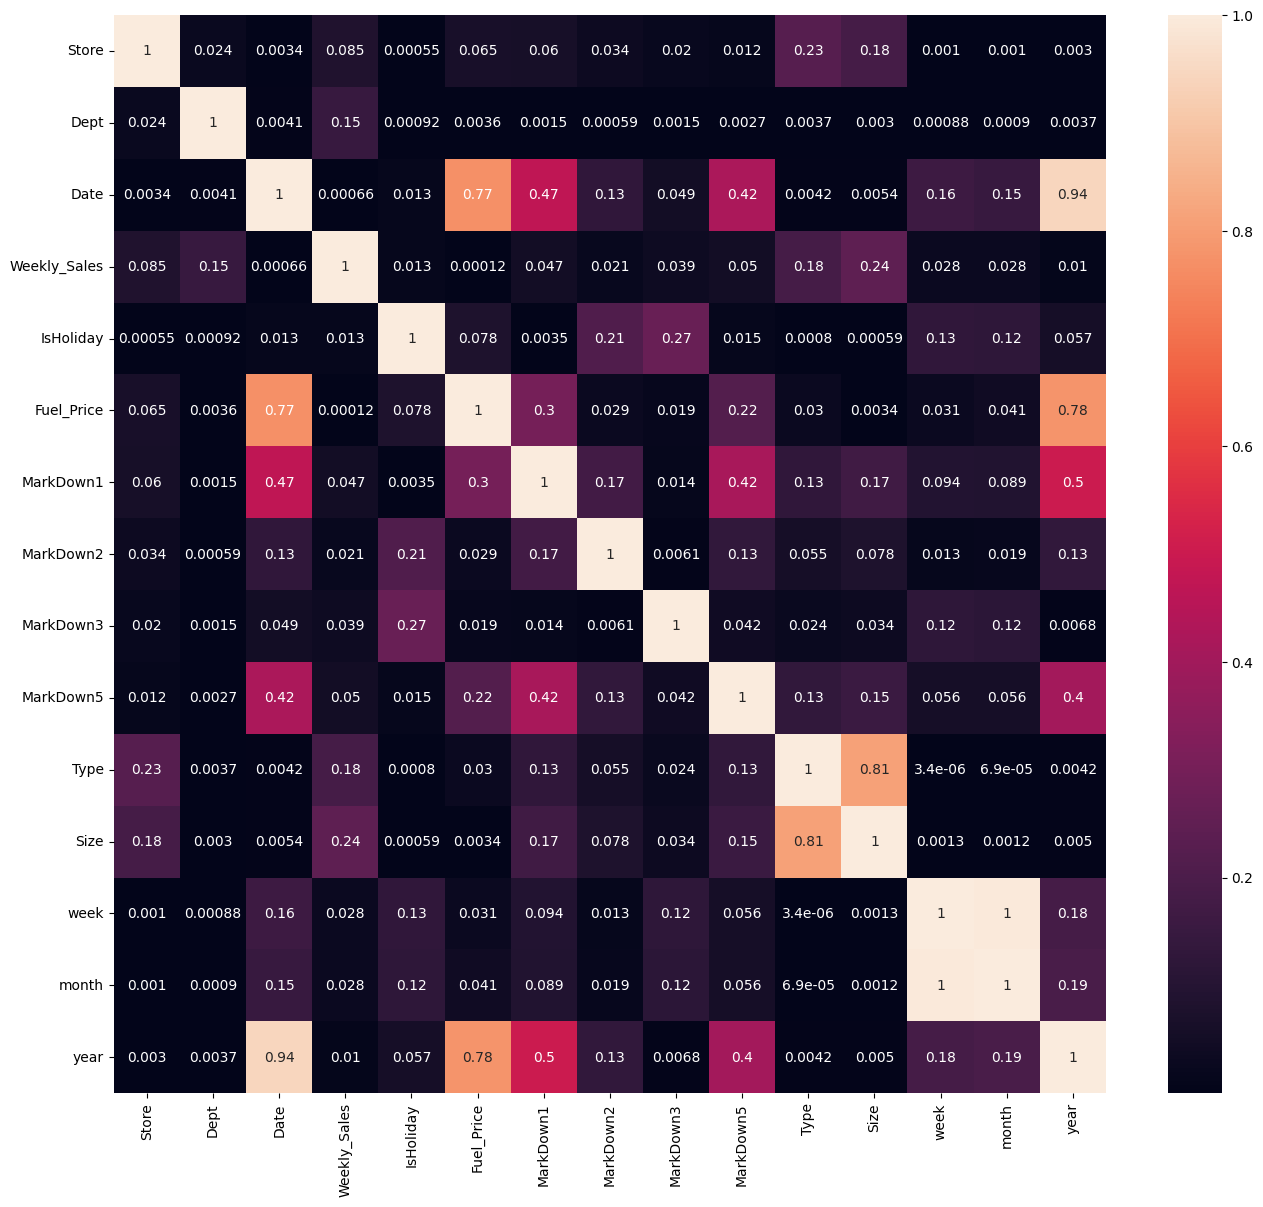

In [40]:
drop_col=['Temperature','MarkDown4','CPI', 'Unemployment']
df_new.drop(drop_col, axis=1, inplace=True)
plt.figure(figsize = (16,14))
sns.heatmap(df_new.corr().abs(),annot=True)    # To see the correlations without dropping columns
plt.show()

In [41]:
df_new = df_new.sort_values(by='Date', ascending=True)
df_new.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown5,Type,Size,week,month,year
0,1,1,2010-02-05,24924.50,0,2.572,0.0,0.0,0.0,0.0,1,151315,5,2,2010
330761,35,3,2010-02-05,14612.19,0,2.784,0.0,0.0,0.0,0.0,2,103681,5,2,2010
330762,35,4,2010-02-05,26323.15,0,2.784,0.0,0.0,0.0,0.0,2,103681,5,2,2010
330763,35,5,2010-02-05,36414.63,0,2.784,0.0,0.0,0.0,0.0,2,103681,5,2,2010
330764,35,6,2010-02-05,11437.81,0,2.784,0.0,0.0,0.0,0.0,2,103681,5,2,2010


## **Train Test Split**

In [42]:
X_new=df_new.drop(columns=['Weekly_Sales','Date'])
y_new=df_new['Weekly_Sales']
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## **Model of RandomForestRegressor**

In [44]:
rf=RandomForestRegressor()
param_grid={
    'max_depth':[35,50],
    'n_estimators':[50,100],
    'max_features':['sqrt'],
    'random_state':[42,100],
    'min_samples_split':[5,10],
    'criterion':['squared_error']
}
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search.fit(X_train, y_train)
grid_search.best_params_

{'criterion': 'squared_error',
 'max_depth': 50,
 'max_features': 'sqrt',
 'min_samples_split': 10,
 'n_estimators': 100,
 'random_state': 42}

In [47]:
rf=RandomForestRegressor(**grid_search.best_params_)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=50, max_features='sqrt', min_samples_split=10,
                      random_state=42)

In [49]:
def model(model,X_train,y_train,X_test, y_test):
  model.fit(X_train, y_train)
  lr_normal_score_train = model.score(X_train, y_train)
  lr_normal_score_test = model.score(X_test, y_test)
  previsoes = model.predict(X_test)
  mae_lr_normal = mean_absolute_error(y_test, previsoes)
  rmse_lr_normal = np.sqrt(mean_squared_error(y_test, previsoes))
  print('Train :', lr_normal_score_train)
  print('Test :', lr_normal_score_test)
  print('Mean Absolute Error :', mae_lr_normal)
  print('Root Mean Square Error :', rmse_lr_normal)
  print('-----------------------------------------------')  
model(rf,X_train,y_train,X_test, y_test)

Train : 0.8802789664150424
Test : 0.7785711523528986
Mean Absolute Error : 6327.325972349976
Root Mean Square Error : 10789.379130765205
-----------------------------------------------
